네이버 영화평 감성분석 - LSTM

In [1]:
!pip install Konlpy > /dev/null

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# 네이버 영화 리뷰 데이터로 검색

train_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep='\t')
test_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep='\t')

In [4]:
print(train_df.shape)
print(test_df.shape) 

(150000, 3)
(50000, 3)


In [5]:
# Null 데이터가 있는지 확인
train_df.document.isna().sum()

5

In [6]:
# Null 데이터 제거
train_df.dropna(how='any', inplace=True)
train_df.shape


(149995, 3)

In [7]:
# 중복 여부 확인
train_df.document.nunique()

146182

In [8]:
# 중복 데이터 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
train_df.shape

(146182, 3)

In [9]:
# 긍정/부정 데이터 분포
train_df.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

In [10]:
# Null 데이터 확인
test_df.document.isna().sum()

3

In [11]:
# Null 데이터 제거
test_df.dropna(how='any', inplace=True)
test_df.shape

(49997, 3)

In [12]:
# 중복 확인
test_df.document.nunique()

49157

In [13]:
# 중복 제거
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49157, 3)

In [14]:
# Label 분포
test_df.label.value_counts()

1    24711
0    24446
Name: label, dtype: int64

# 텍스트 전처리
- train datasets

In [15]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.document = train_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [16]:
# '' 만 남은 데이터 --> np.nan 으로 변경시킨 후 제거
train_df.document.replace('', np.nan, inplace=True)
train_df.document.isna().sum()

789

In [17]:
# Null 데이터 제거
train_df.dropna(how='any', inplace=True)
train_df.shape

(145393, 3)

- test datasets

In [18]:
test_df.document = test_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.document.replace('', np.nan, inplace=True)
test_df.dropna(how='any', inplace=True)
test_df.shape

(48852, 3)

전처리 끝난 데이터 저장

In [19]:
train_df.to_csv('naver_movie_train_전처리완료.csv', sep='\t', index=False)
test_df.to_csv('naver_movie_test_전처리완료.csv', sep='\t', index=False)

# 한글 형태소 분석

In [20]:
from konlpy.tag import Okt
okt = Okt()

In [21]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']


In [22]:
from tqdm.notebook import tqdm

X_train = []
for sentence in tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_str = [word for word in morphs if word not in stopwords]
    X_train.append(tmp_str)

  0%|          | 0/145393 [00:00<?, ?it/s]

In [23]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

4. Keras Tokenizer -> Train/Test dataset

In [24]:
import numpy as np
import tensorflow as tf
seed = 2022 
np.random.seed(seed)
tf.random.set_seed(seed)

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [26]:
t = Tokenizer()
t.fit_on_texts(X_train)

In [27]:
len(t.word_index)

43118

In [28]:
# 빈도수 상위 20000개 단어로 인코딩
num_words = 20000
t = Tokenizer(num_words = num_words)
t.fit_on_texts(X_train)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, train_df.label.values, stratify = train_df.label.values,
    test_size = 0.2, random_state = seed
)

In [30]:
X_test

[['신현준', '곱다', '분투', '안쓰럽다'],
 ['아무리', '밤', '보다', '번', '시도', '번', '모두', '잠들다', '버리다'],
 ['타임', '루프', '소재', '중', '거의', '최악', '감독', '작가', '부터', '자기', '반성', '시간', '갖다'],
 ['책',
  '안',
  '읽다',
  '사람',
  '영화',
  '안',
  '보다',
  '좋다',
  '무슨',
  '야',
  '긴지',
  '모르다',
  '너무',
  '비유',
  '적',
  '표현',
  '것',
  '같다',
  '그렇다'],
 ['여민정',
  '씨',
  '같이',
  '귀엽다',
  '목소리',
  '자다',
  '내다',
  '성우',
  '분',
  '있다',
  '아이돌',
  '개그맨',
  '모자라',
  '젠',
  '애',
  '까지',
  '내',
  '애',
  '이라서',
  '욕',
  '안',
  '진심',
  '민국',
  '아',
  '지아',
  '야',
  '너희',
  '못',
  '너희',
  '흐격사',
  '되다',
  '알다',
  '알다',
  '제',
  '작',
  '진',
  '더',
  '쓰레기',
  '으',
  '휴',
  '성우',
  '지망',
  '생',
  '꿈',
  '짓',
  '밟다',
  '버리다'],
 ['가볍다', '볼', '수', '있다', '영화', 'ㅋ'],
 ['아', '정말', '너무', '재미있다'],
 ['너무', '재밋', '게', '봄', 'ㅋㅋㅋ', 'ㅡ'],
 ['어휴', '너무', '유치하다'],
 ['최악',
  '작품',
  '페이크',
  '다큐',
  '극',
  '리얼리티',
  '추구',
  '다',
  '면서',
  '페이크',
  '다큐',
  '영화',
  '기법',
  '특징',
  '하나',
  '살리다',
  '함',
  '이제',
  '통',
  '않다',
  '뻔하다',
  '전개',
  '심지어',
  '괴물

In [31]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

In [32]:
# 데이터의 최대/평균길이
max(len(s) for s in X_train), sum(map(len, X_train))/ len(X_train)

(70, 10.594717746788865)

In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)
X_train.shape, X_test.shape

((116314, 40), (29079, 40))

In [34]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [35]:
model = Sequential([
        Embedding(num_words, 120 ,input_length = max_len),
        LSTM(128),
        Dense(1, activation = "sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 120)           2400000   
                                                                 
 lstm (LSTM)                 (None, 128)               127488    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,527,617
Trainable params: 2,527,617
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile("adam", "binary_crossentropy", ["accuracy"])
model_path = "best-naver-movie-lstm.h5"
mc = ModelCheckpoint(model_path, save_best_only = True)
es = EarlyStopping(patience = 10)

In [39]:
hist = model.fit(X_train, y_train, validation_split=0.2,
                 epochs = 100, callbacks = [mc, es], batch_size = 128)

Epoch 1/100
727/727 [==============================] - 16s 10ms/step - loss: 0.4033 - accuracy: 0.8145 - val_loss: 0.3644 - val_accuracy: 0.8390
Epoch 2/100
727/727 [==============================] - 6s 9ms/step - loss: 0.3106 - accuracy: 0.8680 - val_loss: 0.3602 - val_accuracy: 0.8420
Epoch 3/100
727/727 [==============================] - 6s 9ms/step - loss: 0.2590 - accuracy: 0.8921 - val_loss: 0.3709 - val_accuracy: 0.8445
Epoch 4/100
727/727 [==============================] - 6s 8ms/step - loss: 0.2137 - accuracy: 0.9123 - val_loss: 0.3968 - val_accuracy: 0.8396
Epoch 5/100
727/727 [==============================] - 6s 9ms/step - loss: 0.1759 - accuracy: 0.9291 - val_loss: 0.4724 - val_accuracy: 0.8349
Epoch 6/100
727/727 [==============================] - 6s 8ms/step - loss: 0.1455 - accuracy: 0.9415 - val_loss: 0.5072 - val_accuracy: 0.8290
Epoch 7/100
727/727 [==============================] - 6s 8ms/step - loss: 0.1193 - accuracy: 0.9535 - val_loss: 0.5710 - val_accuracy: 0.82

In [40]:
best_model = load_model(model_path)
best_model.evaluate(X_test,y_test)

909/909 [==============================] - 5s 4ms/step - loss: 0.3569 - accuracy: 0.8432


[0.3568629324436188, 0.8431513905525208]

6. 실제 데이터 예측


In [41]:
review = "이 영화 개꿀잼 진짜 꼭 보세요!!"

In [43]:
import re
review= re.sub("[^ㄱ-ㅎㅏ-ㅑ가-힣]","", review).strip()

In [45]:
morphs = okt.morphs(sentence, stem=True)
morphs = [word for word in morphs if word not in stopwords]
encoded = t.texts_to_sequences([morphs])
padded = pad_sequences(encoded, maxlen = max_len)
score = best_model.predict(padded)[0][0]
print("긍정" if score > 0.5 else "부정")

긍정


In [48]:
def sentiment_predict(review, tokenizer = t, max_len = max_len):
    morphs = okt.morphs(sentence, stem=True)
    morphs = [word for word in morphs if word not in stopwords]
    encoded = t.texts_to_sequences([morphs])
    padded = pad_sequences(encoded, maxlen = max_len)
    score = best_model.predict(padded)[0][0]
    return f"긍정{score * 100:.2f}%" if score > 0.5 else f"부정{(1- score) * 100:.2f}%"

In [49]:
sentiment_predict("절대 보지 마세요 진짜 존나 재미없고 졸려요")

'긍정62.57%'

7. 학습과정 시각화

In [50]:
y_acc = hist.history["accuracy"]
y_loss = hist.history["loss"]
y_vacc = hist.history["val_accuracy"]
y_vloss = hist.history["val_loss"]
xs = np.arange(1, len(y_acc) + 1)

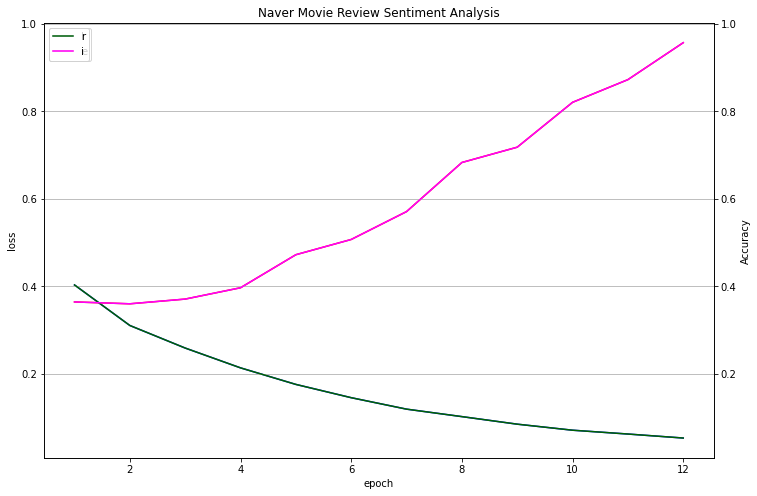

(None, None)

In [52]:
# X 축은 공유
# Y 축의 좌측 : loss, y축의 우측 : accuracy
import matplotlib.pyplot as plt
_, ax0 = plt.subplots(figsize = (12,8))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, c="blue", label="Train loss")
ax0.plot(xs, y_vloss, c="red", label="Validation loss")
ax0.set_ylabel("loss")
ax0.set_xlabel("epoch")
ax1.plot(xs, y_loss, c="darkgreen", label="Trina accuracy")
ax1.plot(xs, y_vloss, c="magenta", label="Validation accuaracy")
ax1.set_ylabel("Accuracy")
ax0.legend("left upper"),ax1.legend("right center")
plt.title("Naver Movie Review Sentiment Analysis")
plt.grid(), plt.show()

8. Conv1D + GRU

In [56]:
from tensorflow.keras.layers import GRU, Dropout, Conv1D, MaxPooling1D

In [57]:
model2 = Sequential([
        Embedding(num_words, 100, input_length = max_len),
        Dropout(0.5),
        Conv1D(64, 7, activation = "relu"),
        MaxPooling1D(7),
        GRU(100),
        Dense(1,activation="sigmoid")
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 100)           2000000   
                                                                 
 dropout_1 (Dropout)         (None, 40, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 34, 64)            44864     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 gru (GRU)                   (None, 100)               49800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                      

In [67]:
model2.compile("adam", "binary_crossentropy", ["accuracy"])
model2_path = "best-naver-movie-conv1d-gru.h5"
mc2 = ModelCheckpoint(model2_path, save_best_only = True)
es2 = EarlyStopping(patience = 10)

In [68]:
hist2 = model2.fit(X_train, y_train, validation_split=0.2,
                 epochs = 100, callbacks = [mc2, es2], batch_size = 128)

Epoch 1/100
727/727 [==============================] - 10s 10ms/step - loss: 0.3706 - accuracy: 0.7580 - val_loss: 0.8231 - val_accuracy: 0.6383
Epoch 2/100
727/727 [==============================] - 5s 7ms/step - loss: 0.3645 - accuracy: 0.7622 - val_loss: 0.8289 - val_accuracy: 0.6375
Epoch 3/100
727/727 [==============================] - 5s 7ms/step - loss: 0.3582 - accuracy: 0.7638 - val_loss: 0.9043 - val_accuracy: 0.6343
Epoch 4/100
727/727 [==============================] - 5s 8ms/step - loss: 0.3553 - accuracy: 0.7637 - val_loss: 0.8725 - val_accuracy: 0.6334
Epoch 5/100
727/727 [==============================] - 5s 7ms/step - loss: 0.3540 - accuracy: 0.7650 - val_loss: 0.9015 - val_accuracy: 0.6345
Epoch 6/100
727/727 [==============================] - 5s 7ms/step - loss: 0.3516 - accuracy: 0.7668 - val_loss: 0.9164 - val_accuracy: 0.6347
Epoch 7/100
727/727 [==============================] - 5s 7ms/step - loss: 0.3507 - accuracy: 0.7677 - val_loss: 0.9293 - val_accuracy: 0.63

In [69]:
best_model2 = load_model(model2_path)
best_model2.evaluate(X_test,y_test)

909/909 [==============================] - 4s 3ms/step - loss: 0.8289 - accuracy: 0.6356


[0.8289297223091125, 0.6355789303779602]